# Data description & Problem statement: 
This data set is collected from recordings of 30 human subjects captured via smartphones enabled with embedded inertial sensors.
In this project, we calculate a model by which a smartphone can detect its owner’s activity precisely. For the dataset, 30 people were used to perform 6 different activities. Each of them was wearing a Samsung Galaxy SII on their waist. Using the smartphone’s embedded sensors (the accelerometer and the gyroscope), the user’s speed and acceleration were measured in 3-axial directions. We use the sensor’s data to predict user’s activity.

* Dataset is imbalanced. The data has 10299 rows and 561 columns.
* This is a Multiclass-classification problem. 

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc.
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build a Deep Neural Network with Keras/TensorFlow. (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)

   # Model Evaluation: 
- Evaluate the Deep Neural Network model with optimized hyperparameters on Test Dataset, by calculating:
     - f1_weighted
     - Confusion matrix

In [1]:
import keras
import sklearn
import tensorflow as tf
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import random as rn
%matplotlib inline

import os
os.environ['PYTHONHASHSEED'] = '0'

# for the reproducable results:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
df_X=pd.read_csv('C:/Users/rhash/Documents/Datasets/Human activity recognition/UCI HAR Dataset/train/X_train.txt' 
                                ,delim_whitespace=True, header = None) 

df_y=pd.read_csv('C:/Users/rhash/Documents/Datasets/Human activity recognition/UCI HAR Dataset/train/y_train.txt' 
                                ,delim_whitespace=True, header = None, names=['Label']) 

df = pd.concat([df_y, df_X], axis=1)  

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.head(3)

,Label,0,1,2,3,4,5,6,7,8,...,551,552,553,554,555,556,557,558,559,560
0,3,0.283203,-0.047024,-0.168986,0.384949,0.176898,-0.310332,0.381757,0.122611,-0.332984,...,0.454181,-0.730593,-0.932568,-0.034924,0.558036,0.258975,-0.854858,-0.784330,0.222960,-0.066506
1,3,0.256904,-0.036623,-0.133856,0.201409,-0.154142,0.344183,0.092771,-0.182114,0.291899,...,0.190745,-0.032958,-0.338095,0.017986,-0.475545,0.942947,-0.567147,-0.665156,0.178975,0.243362
2,1,0.291316,-0.001065,-0.072461,-0.336609,-0.279162,-0.303323,-0.381421,-0.253026,-0.337381,...,0.299767,-0.351997,-0.698254,-0.044663,-0.551806,-0.680774,0.161405,-0.857202,0.192929,0.046716


In [3]:
X=df.drop('Label', axis=1)
y=df['Label']

In [4]:
# We initially devide data into training & test folds:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler=MinMaxScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [6]:
# we build a hold_out dataset for the final validation:

# Resampling:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

#X_r, y_r = SMOTE().fit_sample(X_train, y_train)
X_r, y_r = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)
#X_r, y_r = X_train, y_train

from keras.utils import to_categorical
y_r=to_categorical(y_r)
y_test=to_categorical(y_test)

In [7]:
# KNN with Cross-Validation:
from sklearn.metrics import roc_auc_score
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, average, Input, merge, concatenate
from keras.layers.merge import concatenate
from keras.regularizers import l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_sample_weight
from keras.layers.normalization import BatchNormalization

np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

# a single input layer
inputs = Input(shape=(X_r.shape[1],))


# model
model = Dense(20, activation='relu',  activity_regularizer=l2(0.001), kernel_initializer='glorot_uniform')(inputs)
#model = Dropout(0.1)(model)
model = Dense(40, activation='sigmoid',  activity_regularizer=l2(0.001), kernel_initializer='glorot_uniform')(model)
#model = Dropout(0.1)(model)
model = Dense(20, activation='relu',  activity_regularizer=l2(0.001), kernel_initializer='glorot_uniform')(model)


# output layer
outs = Dense(y_r.shape[1], activation='softmax', activity_regularizer=l2(0.002))(model)

#generate a model from the layers above
model = Model(inputs=inputs, outputs=outs)
model.compile(optimizer='adam',  loss='categorical_crossentropy')


monitor=EarlyStopping(monitor='val_loss', min_delta=0.001, patience=100, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
    
history=model.fit(X_r,y_r, epochs=100, batch_size=8, validation_data=(X_test, y_test),
                                       callbacks=[monitor, checkpointer], verbose=0)
model.load_weights('best_weights.hdf5')

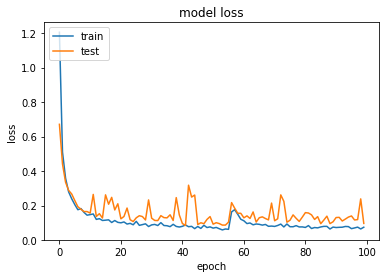

In [8]:
# list all data in history
#print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[307   0   0   0   0   0]
 [  1 267   0   0   0   0]
 [  0   0 246   0   0   0]
 [  0   0   0 314   8   0]
 [  0   0   0  13 330   0]
 [  0   0   0   1   0 351]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.98 0.02 0.  ]
 [0.   0.   0.   0.04 0.96 0.  ]
 [0.   0.   0.   0.   0.   1.  ]]


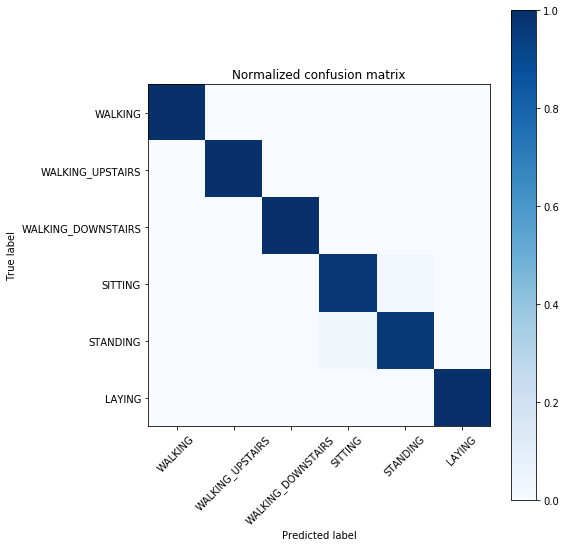

In [9]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]
    
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)

plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

In [10]:
# Classification report: on Validation dataset
report=classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
print(report)

             precision    recall  f1-score   support

          1       1.00      1.00      1.00       307
          2       1.00      1.00      1.00       268
          3       1.00      1.00      1.00       246
          4       0.96      0.98      0.97       322
          5       0.98      0.96      0.97       343
          6       1.00      1.00      1.00       352

avg / total       0.99      0.99      0.99      1838



In [11]:
# Classification report: on Training dataset
report=classification_report(np.argmax(y_r, axis=1), np.argmax(model.predict(X_r), axis=1))
print(report)

             precision    recall  f1-score   support

          1       1.00      1.00      1.00      1055
          2       1.00      1.00      1.00      1055
          3       1.00      1.00      1.00      1055
          4       1.00      0.99      0.99      1055
          5       0.99      1.00      0.99      1055
          6       1.00      1.00      1.00      1055

avg / total       1.00      1.00      1.00      6330

